In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import LogNorm
from astropy.nddata import CCDData
import pandas as pd
import os
import astropy.constants
import astropy.units as u
from astropy.visualization import astropy_mpl_style
from scipy.optimize import curve_fit
plt.style.use(astropy_mpl_style) 
import astroalign as aa
from datetime import datetime
from scipy.fft import fft
from scipy import fftpack
import numpy as np
import ccdproc
from astroML.time_series import lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
from scipy.interpolate import make_interp_spline
from scipy.optimize import minimize
from multiprocessing import Pool, TimeoutError

import warnings
from astroML.utils.exceptions import AstroMLDeprecationWarning
warnings.filterwarnings("ignore", category=AstroMLDeprecationWarning)

In [2]:
gain = 1.25*u.electron/u.adu
readnoise = 11.8*u.electron

base = './data'

master_bias = CCDData(fits.getdata(os.path.join(base, 'processed/master_bias.fits'), ext=0), unit=u.electron)
master_flat = CCDData(fits.getdata(os.path.join(base, 'processed/master_flat.fits'), ext=0), unit=u.electron)

files = [os.path.join(base, f) for f in os.listdir(base) if not os.path.isdir(os.path.join(base, f))]

def extract_header(fname, fields):
    header = fits.getheader(fname, ext=0)
    return [fname] + [header[f] for f in fields]

fields = ['EXPTIME', 'FILTER', 'IMAGETYP', 'BZERO', 'CCD-TEMP', 'INSTRUME', 'DATE-OBS']
data = pd.DataFrame([extract_header(f, fields) for f in files], columns = ["Name"] + fields).sort_values('DATE-OBS')
data

,Name,EXPTIME,FILTER,IMAGETYP,BZERO,CCD-TEMP,INSTRUME,DATE-OBS
0,./data\J1903+6035_sdss_g_20210513_064114.fits,120.0,sdss_g,LIGHT,32768.0,-26.874788,Flarecam,2021-05-13T06:41:14.500
1,./data\J1903+6035_sdss_g_20210513_065343.fits,120.0,sdss_g,LIGHT,32768.0,-27.009947,Flarecam,2021-05-13T06:53:43.500
2,./data\J1903+6035_sdss_g_20210513_070053.fits,100.0,sdss_g,LIGHT,32768.0,-26.887361,Flarecam,2021-05-13T07:00:53.790
3,./data\J1903+6035_sdss_g_20210513_070907.fits,100.0,sdss_g,LIGHT,32768.0,-28.078652,Flarecam,2021-05-13T07:09:07.890
4,./data\J1903+6035_sdss_g_20210513_071104.fits,100.0,sdss_g,LIGHT,32768.0,-28.201239,Flarecam,2021-05-13T07:11:04.810
...,...,...,...,...,...,...,...,...
122,./data\J1903+6035_sdss_g_20210513_110638.fits,100.0,sdss_g,LIGHT,32768.0,-28.166663,Flarecam,2021-05-13T11:06:38.930
123,./data\J1903+6035_sdss_g_20210513_110848.fits,100.0,sdss_g,LIGHT,32768.0,-28.235815,Flarecam,2021-05-13T11:08:48.720
124,./data\J1903+6035_sdss_g_20210513_111108.fits,100.0,sdss_g,LIGHT,32768.0,-27.041380,Flarecam,2021-05-13T11:11:08.730
125,./data\J1903+6035_sdss_g_20210513_111324.fits,100.0,sdss_g,LIGHT,32768.0,-27.145107,Flarecam,2021-05-13T11:13:24.670


In [3]:
def load_image(row):
    img = fits.getdata(row['Name'], ext=0)
    
    data = CCDData(img, unit=u.adu)
    data_with_deviation = ccdproc.create_deviation(
        data, gain=gain,
        readnoise=readnoise, disregard_nan=True)
    data_with_deviation.header['exposure'] = 100.0  # for dark subtraction
    gain_corrected = ccdproc.gain_correct(data_with_deviation, gain)
    # img_cleaned = ccdproc.cosmicray_lacosmic(gain_corrected)
    bias_subtracted = ccdproc.subtract_bias(gain_corrected, master_bias)
    reduced_image = ccdproc.flat_correct(bias_subtracted, master_flat)
    return reduced_image

def show_field(img, main, refs, shift=None):    
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    im = ax.imshow(img, vmax=1000, cmap='binary')
    plt.grid(False)
    if shift is None:
        shift = np.array([0, 0])
    
    c_main = patches.Circle(main + shift, 6, linewidth=1, linestyle='-',
                                 edgecolor='r', facecolor="none")
    ax.add_patch(c_main)
    
    for i, c in enumerate(refs):
        x, y = c

        rect = patches.Circle((x, y) + shift, 6, linewidth=1, linestyle='--',
                                 edgecolor='g', facecolor="none")
        ax.add_patch(rect)

             
    fig.colorbar(mappable = im)
    plt.show()
    
def compute_transform(img_ref, img_other):
    T, matches = aa.find_transform(img_ref, img_other, detection_sigma=2)
    shift = np.array([(d[0]-s[0], d[1]-s[1]) for s, d in zip(matches[0], matches[1])]).mean(axis=0)
    return shift

def optimize_star(img, p, r):
    xx = np.arange(img.shape[0])
    yy = np.arange(img.shape[1])

    def f(x):
        fwhm = 2*r
        return -np.sum(img * np.exp(-4*np.log(2) * ((xx[None, :]-x[0])**2 + (yy[:, None]-x[1])**2) / fwhm**2))
    
    res = minimize(f, p, method='powell', options={'disp': False})
    return res

def aperture(img, p, r):
    xx = np.arange(img.shape[0])
    yy = np.arange(img.shape[1])
    
    res = optimize_star(img, p, r)
    p = res.x
    y0, x0 = p
    rpix = np.sqrt((xx[:, None]-x0)**2 + (yy[None, :]-y0)**2)
    apPhotImage = img.copy()
    apPhotImage[rpix > r] = 0
    return apPhotImage.sum()

# Similar to Figure 10.15 in the textbook

# plot phased light curve with times t, observations y_obs, and period P
def plot_phased(t, y_obs, P, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,7))

    phase = t / P - np.floor(t/P)
    ax.errorbar(phase, y_obs, sigma_y, fmt='.k', lw=1, ecolor='gray')
    ax.set_xlabel('phase')
    ax.set_ylabel('magnitude')
    ax.set_xlim(-0.05, 1.05)
    
# plot phased light curve and periodogram
# times: t, observations: y_obs, period: P_fit,
# 1%/5% false alarm probability thresholds for P_LS: sig1/sig5
def plot_LS(t, y_obs, P_fit, sig1, sig5):
    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(14, 7))
    fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

    # First panel: the data
    ax = fig.add_subplot(211)
    plot_phased(t, y_obs, P_fit, ax=ax)

    # Second panel: the periodogram & significance levels
    ax1 = fig.add_subplot(212)
    ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
    ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black', label="99% significance level")
    ax1.plot([period[0], period[-1]], [sig5, sig5], '-.', c='black', label="95% significance level")
    ax1.legend()

    # ax1.annotate("", (P_fit, 0.95), (P_fit, 1.10), ha='center', arrowprops=dict(arrowstyle='->'))
    ax1.axvline(P_fit)

    ax1.set_xlim(period[0], period[-1])
    ax1.set_ylim(-0.01, 0.35)

    ax1.set_xlabel(r'period (seconds)')
    ax1.set_ylabel('power')

    # Twin axis: label BIC on the right side
    ax2 = ax1.twinx()
    ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, sigma_y)))
    print(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, sigma_y)))
    ax2.set_ylabel(r'$\Delta BIC$')

    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))

    plt.show()

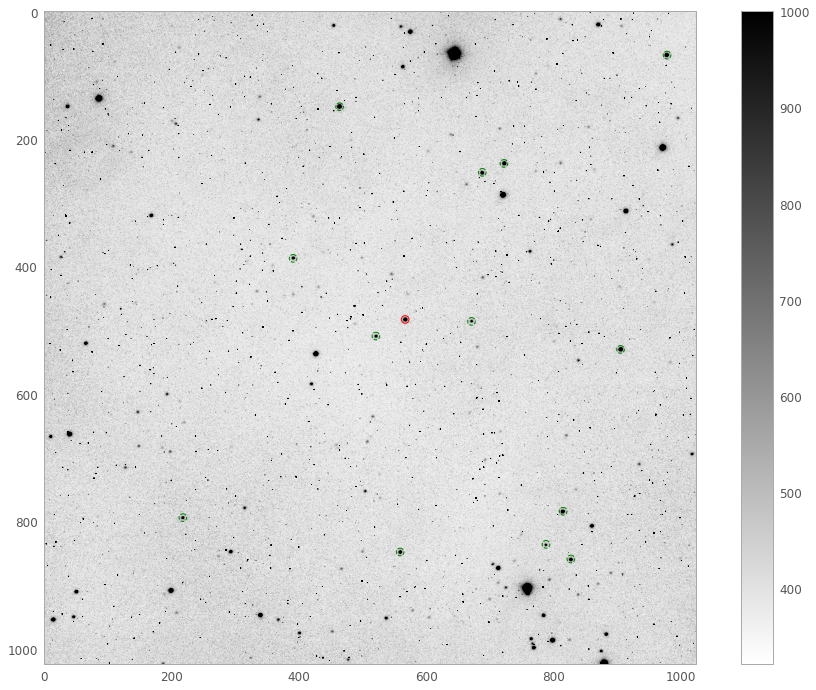

In [10]:
n_ref = 83
star = (567, 483)
null_star = (420, 584)
null_star = (427, 537)
refs = [(671, 486), (521, 509), (218, 794), (905, 530), 
        (722, 238), (688, 252), (464, 149), (559, 848), 
        (391, 387), (815, 784), (788, 836), (827, 859), (978, 68)]
show_field(load_image(data.iloc[n_ref]), star, refs)

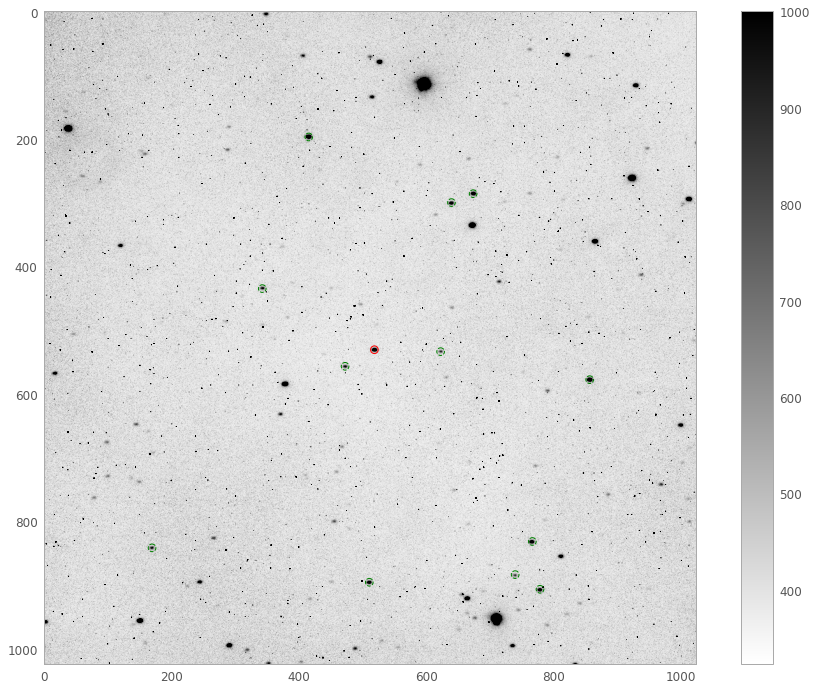

In [36]:
n = 21
img = load_image(data.iloc[n])
shift = compute_transform(load_image(data.iloc[n_ref]), img)
show_field(img, star, refs, shift)

[473.58879853 559.48036583]


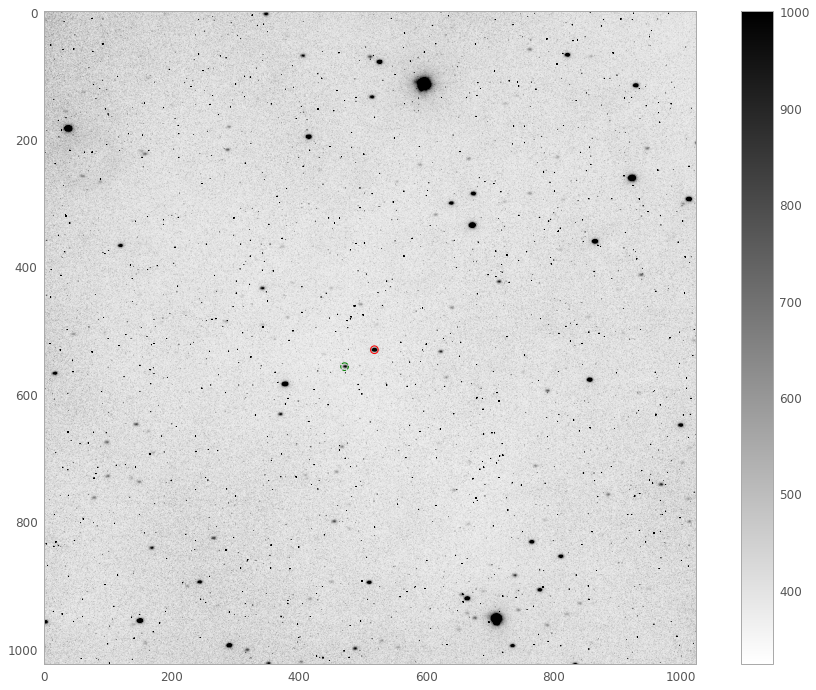

array([471.77421402, 557.02421491])

In [37]:
n = 1
print(refs[n] + shift + (1,3))

# shift = compute_transform(load_image(data.iloc[n_ref]), img)
res = optimize_star(img, refs[n] + shift + (1,3), 6)
show_field(img, star + shift, [res.x])
res.x

In [38]:
def compute_relative_flux(star, r = 6):
    for i in range(3, 100):
        if i in range(45, 49):
            continue
        img = load_image(data.iloc[i]).data
        shift = compute_transform(load_image(data.iloc[n_ref]), img)
        x = aperture(img, star + shift, r) / np.array([aperture(img, r + shift, 6) for r in refs]).mean()
        yield datetime.fromisoformat(data.iloc[i]['DATE-OBS']).timestamp(), x

def process_one(i):
    star = process_one.star
    r = process_one.r
    img = load_image(data.iloc[i]).data
    shift = compute_transform(load_image(data.iloc[n_ref]), img)
    x = aperture(img, star + shift, r) / np.array([aperture(img, r + shift, 6) for r in refs]).mean()
    return datetime.fromisoformat(data.iloc[i]['DATE-OBS']).timestamp(), x

def initializer(star,r):
    process_one.star = star
    process_one.r = r

def compute_relative_flux_parallel(star, r = 6):
    with Pool(processes=4, initializer = initializer, initargs = (star, r)) as pool:
        return pool.imap(process_one, np.setdiff1d(np.arange(3, 110), range(45, 49)))

In [39]:
# fiter = compute_relative_flux_parallel(star, r = 6)
# ts = list(fiter)

In [40]:
fiter = compute_relative_flux(star, r = 6)
ts = list(fiter)

In [41]:
tsa = np.array(ts)
t = tsa[:, 0] - tsa[0, 0]
y_obs = tsa[:, 1]
sigma_y = 0.02

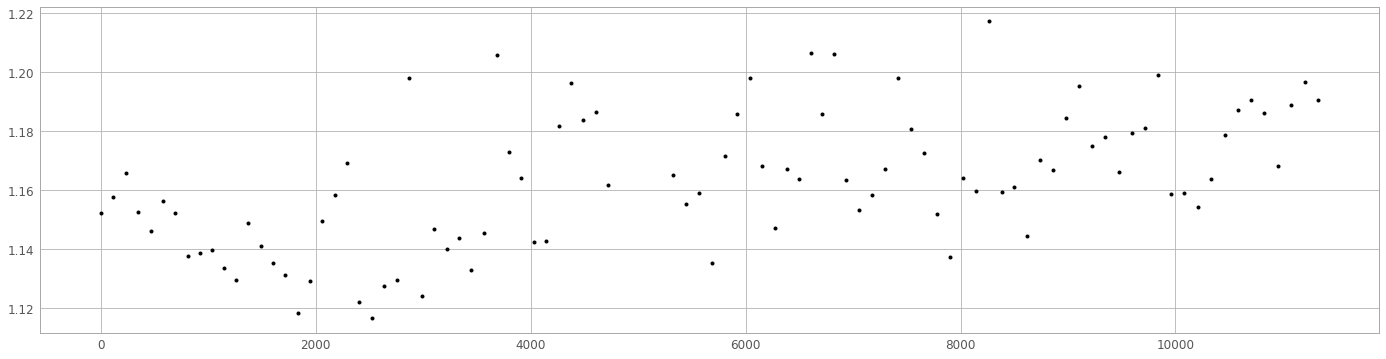

In [48]:
plt.figure(figsize=(24, 6))
plt.plot(tsa[:,0] - tsa[0, 0], tsa[:,1], 'k.') 

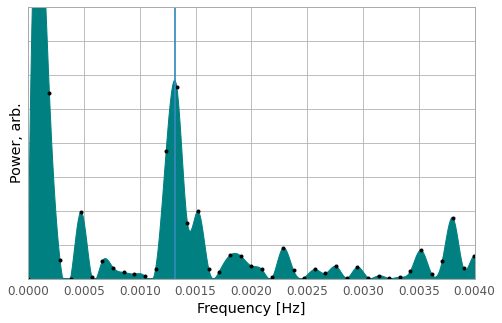

In [62]:
sig_fft = fftpack.fft(tsa[:, 1] - tsa[:, 1].mean())
power = np.abs(sig_fft)**2
sample_freq = fftpack.fftfreq(len(tsa[:, 0]), d=113)

n = int(len(sample_freq)/2)
X_Y_Spline = make_interp_spline(sample_freq[0:n], power[0:n])
 
X_ = np.linspace(0, np.max(sample_freq), 400)
Y_ = X_Y_Spline(X_)
Y_[Y_ < 0] = 0

plt.figure(figsize=(8, 5))

plt.fill_between(X_, Y_, color='teal')
plt.plot(sample_freq[0:n], power[0:n], 'k.')
plt.axvline(1/760)
plt.xlim([0, 0.004])
plt.ylim([0, 0.4])
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power, arb.')
plt.show()

In [49]:
#------------------------------------------------------------
# Compute periodogram
period = np.linspace(100, 1400, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, sigma_y, omega, generalized=True)

# find the highest peak
P_fit = period[PS.argmax()]

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, sigma_y, omega, generalized=True,
                           N_bootstraps=500, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

<ipython-input-34-4d13ce34c86e>:110: UserWarning: Attempting to set identical bottom == top == -13.597798479459769 results in singular transformations; automatically expanding.
  ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, sigma_y)))


(-13.597798479459769, -13.597798479459769)


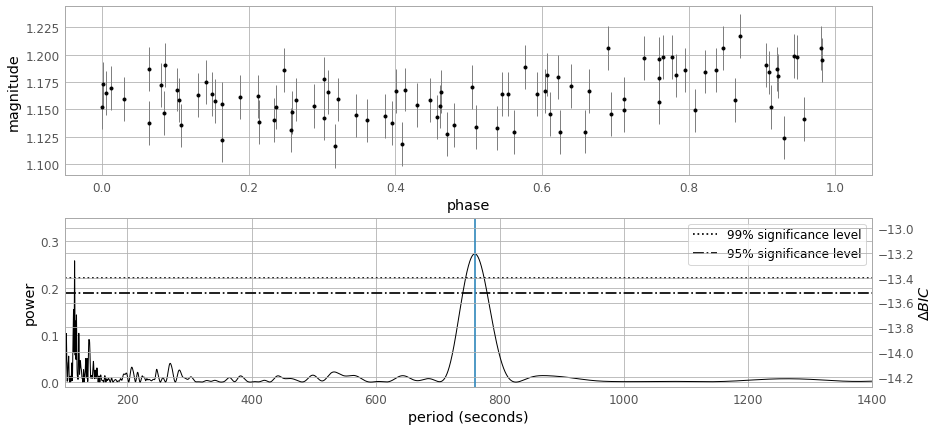

Location of highest periodogram peak, P_fit = 759.946 seconds


In [50]:
plot_LS(t, y_obs, P_fit, sig1, sig5)
print(f"Location of highest periodogram peak, P_fit = {P_fit:.3f} seconds")

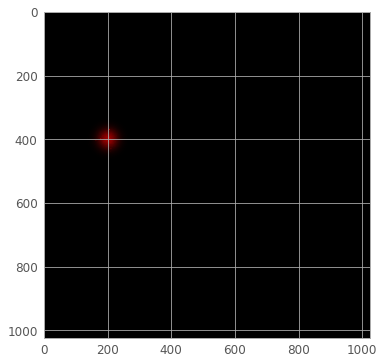

In [24]:
xx = np.arange(img.shape[0])
yy = np.arange(img.shape[1])
x = (200,400)
fwhm=50
plt.imshow(img * np.exp(-4*np.log(2) * ((xx[None, :]-x[0])**2 + (yy[:, None]-x[1])**2) / fwhm**2), vmax=1000)

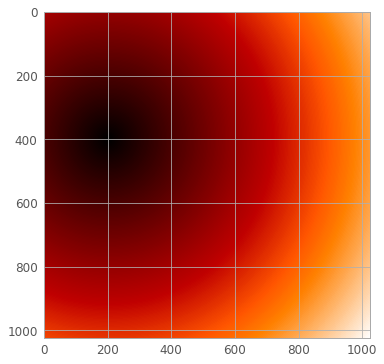

In [25]:
rpix = np.sqrt((xx[:, None]-x[1])**2 + (yy[None, :]-x[0])**2)
plt.imshow(rpix)

In [26]:
np.setdiff1d(np.arange(3, 110), range(45, 49))

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109])

In [58]:
t

array([    0.        ,   116.91999984,   234.19999981,   350.55999994,
         463.82999992,   577.22999978,   693.88999987,   808.22999978,
         922.61999989,  1035.        ,  1147.69999981,  1260.36999989,
        1374.05999994,  1487.05999994,  1601.54999995,  1716.02999997,
        1831.19999981,  1946.72999978,  2061.39999986,  2175.8499999 ,
        2288.69999981,  2404.37999988,  2521.13999987,  2637.7099998 ,
        2754.3599999 ,  2870.72999978,  2987.02999997,  3103.67999983,
        3218.08999991,  3333.3599999 ,  3449.6099999 ,  3566.94999981,
        3683.37999988,  3801.07999992,  3913.79999995,  4030.02999997,
        4147.22999978,  4261.08999991,  4377.53999996,  4491.32999992,
        4608.46999979,  4721.65999985,  5324.15999985,  5444.30999994,
        5564.2099998 ,  5684.39999986,  5806.15999985,  5923.99000001,
        6039.5       ,  6157.41999984,  6276.43999982,  6384.63999987,
        6493.94999981,  6604.28999996,  6715.63999987,  6824.8499999 ,
      